In [1]:
# 資科工碩一 309551177 許珈瑋 HW01

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def Fitting_line_math(A,vec_b,vec_x):
    n=A.shape[1]
    print("Fitting line:", end=" ") #print the mathematical form of the fitting curve
    for i in range(n-1):
        print(vec_x[i][0], "X^", n-i-1 ," + ",end="")
    print(vec_x[n-1][0])
    print("Total error: ",np.sum(np.square(A@vec_x-vec_b))) #print the total error of the fitting line

In [4]:
def visualization(A,vec_b,vec_x_rLSE,vec_x_Newton,data):
    n=A.shape[1]
    x = np.linspace(np.max(data[:,0]),np.min(data[:,0]),100) #samplizing data points' x coordinate
    #rLSE model
    print("<<<rLSE>>>")
    Fitting_line_math(A,vec_b,vec_x_rLSE)
    plt.subplot(2,1,1) #drawing on the top half of the paper
    plt.title("rLSE")
    plt.scatter(data[:,0],data[:,1]) #raw data
    y_rLSE=0 #print how the fitting curve looks like
    for i in range(n):
        y_rLSE+=vec_x_rLSE[i][0]*np.power(x,n-i-1)
    plt.plot(x,y_rLSE)

    #Newton model
    print("<<<Newton>>>")
    Fitting_line_math(A,vec_b,vec_x_Newton)
    plt.subplot(2,1,2) #drawing on the bottom half of the paper
    plt.title("Newton")
    plt.scatter(data[:,0],data[:,1]) #raw data
    y_Newton=0 #print how the fitting curve looks like
    for i in range(n):
        y_Newton+=vec_x_Newton[i][0]*np.power(x,n-i-1)
    plt.plot(x,y_Newton)

### Regularized Least Square Error with L2(Ridge)
---
model : A$\vec x$ = $\vec b$ ( ax+b=y )

regularized loss : $||A\vec x-\vec b||^2$ + $\lambda ||\vec x||^2$

$\rightarrow \vec x = (A^TA+\lambda I)^{-1}A^T \vec b$

A=data points' x coordinate
$\begin{bmatrix}
x_0 & 1 \\
x_1 & 1 \\
... & 1 \\
x_n & 1
\end{bmatrix}$

$\vec x$=coefficients
$\begin{bmatrix}
a \\
b \\
\end{bmatrix}$

$\vec b$=data points' y coordinate
$\begin{bmatrix}
y_0 \\
y_1 \\
... \\
y_n
\end{bmatrix}$

In [5]:
#for rLSE , LU-decomposition , M=LU
def LU_decomposition(M):
    n=M.shape[0]
    M=M.astype(float) #必須轉成浮點數 , 不然之後運算可能會在不知不覺被四捨五入或是無條件捨去...
    #M=LU , find L and U
    U=M.copy()
    L=np.identity(n)
    I=np.identity(n)
    for i in range(n-1):
        for j in range(i+1,n):
            c=-U[j][i]/U[i][i]
            U[j]=U[j]+c*U[i] #gradually eliminate to form the triangle
            L[j][i]=I[j][i]-c*I[i][i] #E1E2E3...EkA=U , A=Ek^(-1)...E3^(-1)E2^(-1)E1^(-1)U , A=LU , L=Ek^(-1)...E3^(-1)E2^(-1)E1^(-1) , Ek^(-1)=-Ek if not on diagonal , L=-Ek-...-E3-E2-E1
    #print(L.round(3),"L")
    #print(U.round(3),"U")
    #print(M.round(3),"M")
    #print((L@U).round(3),"L@U")
    return L,U

In [6]:
#for rLSE , find the inverse of matrix M using LU-decomposition
def inverse(M):
    n=M.shape[0] #M is a square matrix, so you can retrieve any dimension's size of M
    I=np.identity(n)
    lM,uM=LU_decomposition(M)
    #MM^(-1)=I , LUM^(-1)=I
    #LZ=I , solve Z which is also the inverse of L
    Z=np.identity(n) #declare matrix Z
    for i in range(n):
        for j in range(n):
            summ=0
            for k in range(i):
                summ=summ+lM[i][k]*Z[k][j]
            Z[i][j]=(I[i][j]-summ)/lM[i][i]
    #print(Z)
    #UM^(-1)=Z , solve M^(-1)
    invM=np.identity(n) #declare matrix invM
    for i in range(n-1,-1,-1):
        for j in range(n-1,-1,-1):
            summ=0
            for k in range(i+1,n):
                summ=summ+uM[i][k]*invM[k][j]
            invM[i][j]=(Z[i][j]-summ)/uM[i][i]
    #print(invM)
    return invM

In [7]:
#check for example
#m=2
#M=np.random.randint(5,30,(m,m))
#M=np.random.rand(n,n)

#from numpy.linalg import inv
#print(inverse(M)) #my function
#print(inv(M)) #answer's function

In [8]:
#LSE : use LU-decomposition to find (A.TA+lambda*I)^-1
def rLSE(A,vec_b,lambdaa):
    n=A.shape[1] #A.shape[1] means the number of polynomial bases
    ATAlI=A.T@A+lambdaa*np.eye(n)
    #Now, we can construct our model's coefficients vec_x
    vec_x=inverse(ATAlI)@A.T@vec_b
    return vec_x

### Newton's method ###

regularized loss : 

$f(\vec x)
=||A\vec x-\vec b||^2 
=(A\vec x-\vec b)^T(A\vec x-\vec b) 
=\vec x^TA^TA\vec x-2\vec x^TA^T\vec b+\vec b^T\vec b$

Addition,

$\nabla f=2A^TA\vec x-2A^T\vec b$

$Hf(\vec x)=2A^TA$

Hence,

$\vec x_{n+1}=\vec x_n \cdot (2A^TA\vec x_n-2A^T\vec b) \cdot (2A^TA)^{-1}$

In [9]:
#Newton's method
def Newton(A,vec_b):
    n=A.shape[1]
    xt0=np.random.rand(n,1)
    eps=100
    while eps>1e-6:
        xt1=xt0-inverse(2*A.T@A)@(2*A.T@A@xt0-2*A.T@vec_b)
        eps=abs(np.sum(np.square(xt1-xt0))/n)
        xt0=xt1
    vec_x=xt0
    return vec_x

In [10]:
def run():
    #initialize
    #path="testfile.txt"
    path=input("path: ") #path and the name of input file consists data points
    n=int(input("number of polynomial bases: "))
    lambdaa=int(input("lambdaa: "))
    
    #read data
    data = np.loadtxt(path, delimiter=',', unpack=False)
    amount=int(data.size/2) #the amount of data in 2D
    
    #set data maxtrix A, label vector b
    A=np.empty((amount,n))
    for j in range(n): #n=3 -> j=0,1,2
        A[:,n-j-1]=np.power(data[:,0],j)
    vec_b=data[:,-1:]
    
    #get the trained model parameter
    vec_x_rLSE=rLSE(A,vec_b,lambdaa)
    vec_x_Newton=Newton(A,vec_b)
    
    #visulization
    visualization(A,vec_b,vec_x_rLSE,vec_x_Newton,data)

path:  testfile.txt
number of polynomial bases:  3
lambdaa:  10000


<<<rLSE>>>
Fitting line: 0.8345332827002858 X^ 2  + 0.09314819831918816 X^ 1  + 0.046950699273469274
Total error:  22649.738493024153
<<<Newton>>>
Fitting line: 3.023853393486571 X^ 2  + 4.906190263863799 X^ 1  + -0.23140175608771718
Total error:  26.559959499333054


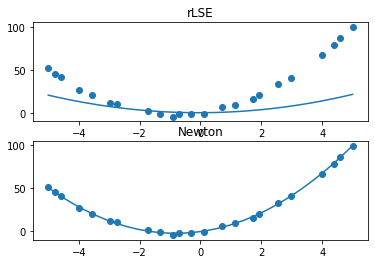

In [15]:
run()

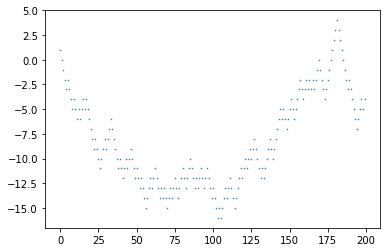

In [101]:
#randomly create data to check for the model presentation
import matplotlib.pyplot as plt
import random
position = 0
walk=np.empty((steps,2))
steps = 200
for i in range(steps):
  step= 1 if random.randint(0, 1) else -1
  position += step
  walk[i][0]=i
  walk[i][1]=position
fig = plt.figure()
plt.scatter(walk[:,0],walk[:,1],s=0.3)
plt.show()